### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003696379, 'queue_time': 0.236356566, 'total_time': 0.053696379}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0edcee01-b5b2-4f8c-bbbb-22f00e2e447b-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

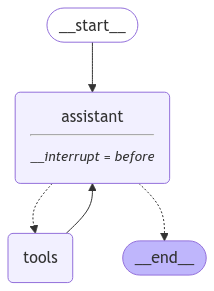

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
## human in the loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}



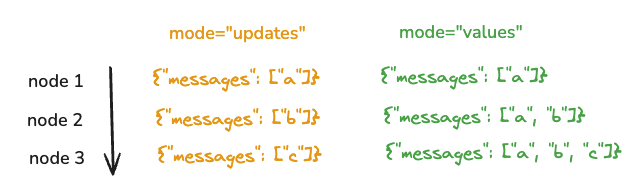

In [5]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state=graph.get_state(thread)
state.next

('assistant',)

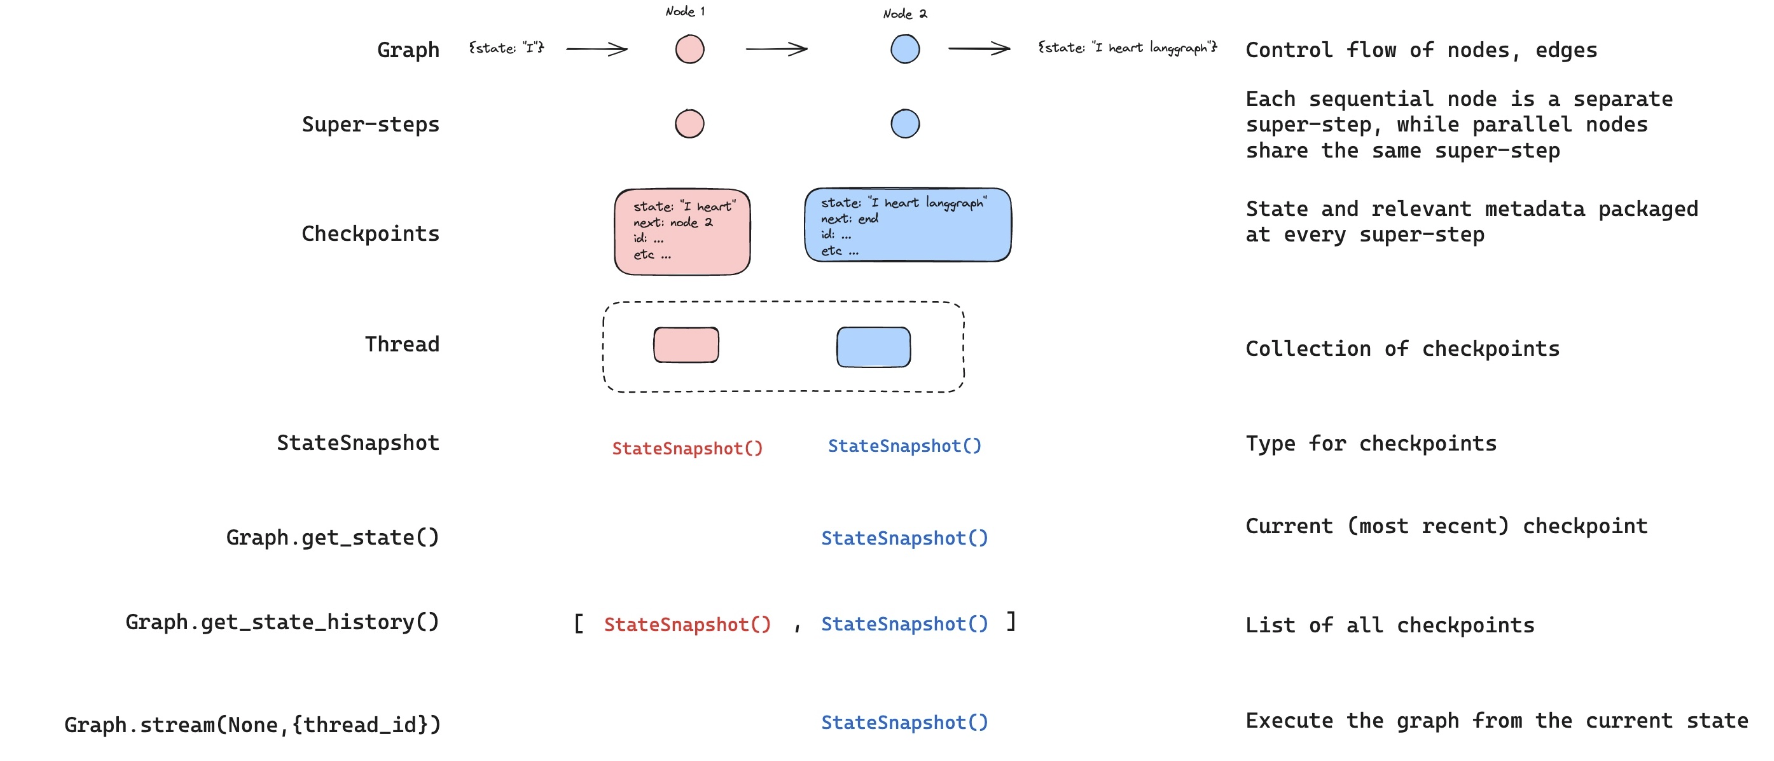

In [39]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='193dbdc7-ebf1-4219-b066-0f1bdb79f954')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff1cfa-5acb-6288-8000-7c929c73ff84'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-02-23T10:19:21.185754+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff1cfa-5ac8-6b7f-bfff-54e52241bd51'}}, tasks=(PregelTask(id='559a17d7-68c4-f766-7c49-dbfd200e7b34', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [7]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pksn)
 Call ID: call_pksn
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [8]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Edit Human Feedback

In [9]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [10]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, actually multiply 15 and 5!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff1d3c-4c12-610e-8006-7362bf29d06f'}}

In [11]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pksn)
 Call ID: call_pksn
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 15 and 5!


In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rha9)
 Call ID: call_rha9
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


In [13]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pksn)
 Call ID: call_pksn
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rha9)
 Call ID: call_rha9
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


In [44]:
state=graph.get_state(thread)
state.next

('assistant',)

In [45]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

The product of 15 and 5 is 75.


### Wait for a USer Input

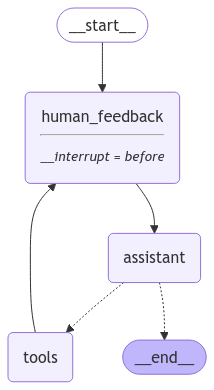

In [51]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no multiply 4 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1gd3)
 Call ID: call_1gd3
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: multiply

12


In [54]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The multiplication of 4 and 3 is 12.
